<a href="https://colab.research.google.com/github/richybu/gis_code/blob/main/obesity_change_with_funding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving finaldata_from_originalcolumns.xlsx to finaldata_from_originalcolumns.xlsx


In [3]:
import io
obesity = pd.read_excel(io.BytesIO(uploaded['finaldata_from_originalcolumns.xlsx']))

In [4]:
obesity.columns

Index(['change_cases_per_pop', 'clean_per_mean_pop', 'eviron_per_mean_pop',
       'health_per_mean_pop', 'school_per_mean_pop', 'media_per_mean_pop',
       'counselling_per_mean_pop'],
      dtype='object')

In [5]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [8]:
# use VIF on obesity
obesity_VIF = drop_column_using_vif_(obesity.drop('change_cases_per_pop', axis=1))
print("The columns remaining after VIF selection are:")
print(obesity_VIF.columns)

The columns remaining after VIF selection are:
Index(['clean_per_mean_pop', 'eviron_per_mean_pop', 'health_per_mean_pop',
       'school_per_mean_pop', 'media_per_mean_pop',
       'counselling_per_mean_pop'],
      dtype='object')


In [9]:
#build regression model
model_obesity = sm.OLS(endog=obesity[['change_cases_per_pop']], exog=sm.add_constant(obesity_VIF)).fit()
model_obesity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     change_cases_per_pop   R-squared:                       0.162
Model:                              OLS   Adj. R-squared:                  0.127
Method:                   Least Squares   F-statistic:                     4.668
Date:                  Sat, 13 Nov 2021   Prob (F-statistic):           0.000227
Time:                          16:46:26   Log-Likelihood:                 1057.7
No. Observations:                   152   AIC:                            -2101.
Df Residuals:                       145   BIC:                            -2080.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0002    7.2e-05      2.173      0.031    1.42e-05       0.000
clean_per_mean_pop       -7.745e-05      0.000     -0.329      0.743      -0.001       0.000
eviron_per_mean_pop          0.0004      0.000      1.686      0.094   -6.62e-05       0.001
health_per_mean_pop          0.0002      0.001      0.335      0.738      -0.001       0.001
school_per_mean_pop         -0.0005      0.000     -3.027      0.003      -0.001      -0.000
media_per_mean_pop           0.0016      0.000      3.398      0.001       0.001       0.002
counselling_per_mean_pop     0.0011      0.001      1.413      0.160      -0.000       0.003
==============================================================================
Omnibus:                        2.139   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                2.026
Skew:                           0.201   Prob(JB):                        0.363
Kurtosis:                       2.601   Cond. No.                         42.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

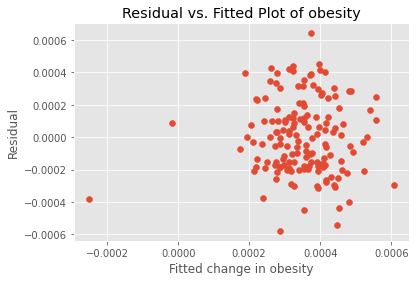

In [10]:
# plot residuals
plt.scatter(model_obesity.fittedvalues, model_obesity.resid)
# adding title and labels
plt.xlabel('Fitted change in obesity')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of obesity')
plt.show()